## Description
This notebook analyses the features of the central model with SHAP.

## Imports

In [1]:
import torch, shap

import pandas as pd
import matplotlib.pyplot as plt

from configuration import Configuration
from os.path import join as path
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=RuntimeWarning)

from model import Model

# Configuration
c = Configuration()

/Users/ejozric/Dipterv/dipterv_python_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load central model

In [2]:
CENTRAL_CASE = "FC-All"

features = c._flowstats + c._pstats + c._pflowstats + c._pstats_subdirs
columns = features + c.appl

in_features = len(features)
out_features = len(c.classes)

model = Model(in_features, out_features)
model.load_state_dict(torch.load(path(c.path_results, "scenarios", "CL", CENTRAL_CASE, "best_model.torch")))
model.eval()

Model(
  (fc): Sequential(
    (0): Linear(in_features=283, out_features=566, bias=False)
    (1): BatchNorm1d(566, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.15, inplace=False)
    (4): Linear(in_features=566, out_features=849, bias=False)
    (5): BatchNorm1d(849, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (6): LeakyReLU(negative_slope=0.1)
    (7): Dropout(p=0.15, inplace=False)
    (8): Linear(in_features=849, out_features=849, bias=False)
    (9): BatchNorm1d(849, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.1)
    (11): Dropout(p=0.15, inplace=False)
    (12): Linear(in_features=849, out_features=1132, bias=False)
    (13): BatchNorm1d(1132, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (14): LeakyReLU(negative_slope=0.1)
    (15): Dropout(p=0.15, inplace=False)
    (16): Linear(in_features=1132

## Load test data

In [3]:
test_path = path(c.path_dataset, "4-dataset", "CL", "test.parquet")

df = pd.read_parquet(test_path, columns=columns)
df = df.iloc[0:60]

X, y = df.drop(columns=c.appl), df[c.app]
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.long)

## SHAP Analysis
The SHAP score can vary between inputs as little differnes could favor other features each time. However, what stated in my thesis is still holds to all SHAP results: The most impact will be always DST_PS_2 and the other features will be from the beginning of the flow. Although, scenarios can be constucted hipotetically to favor a specific feature (for example use only those flows which can be easily distinguished by their duration or other clear criteria).

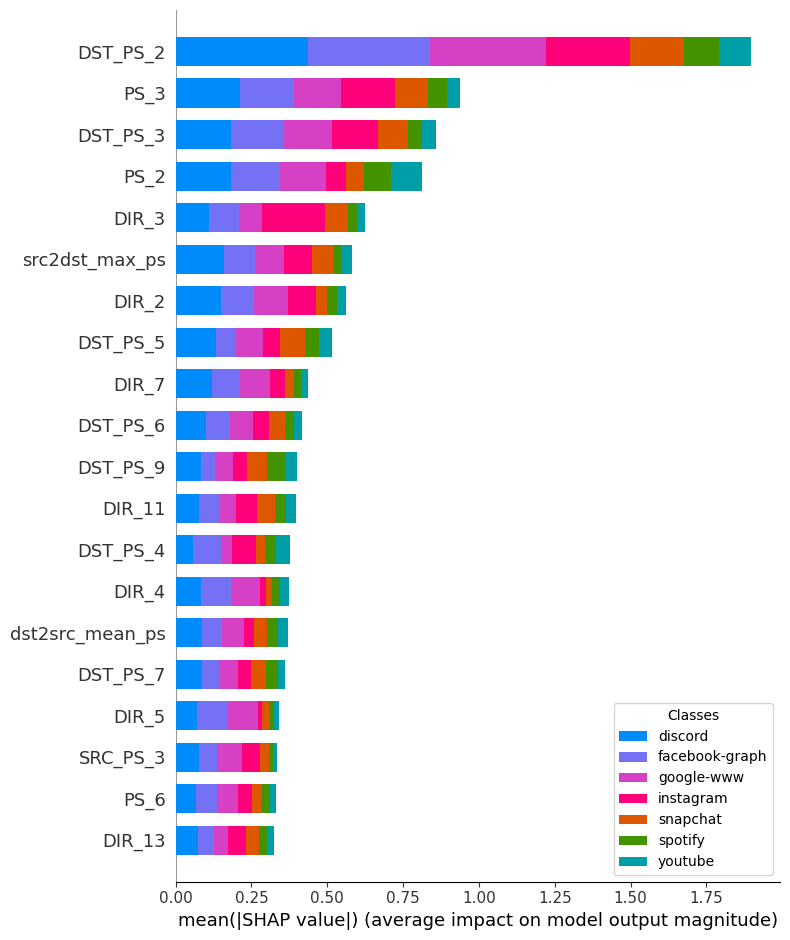

In [4]:
sample_data, labels = X, y
    
explainer = shap.DeepExplainer(model, sample_data[:50])

# Compute SHAP values
shap_values = explainer.shap_values(sample_data[50:60], check_additivity=False)

shap.summary_plot(shap_values, sample_data[50:60], plot_type="bar", show=False, feature_names=df.columns)

# Get current legend handles and labels
class_names = ["discord", "facebook-graph", "google-www", "instagram", "snapchat", "spotify", "youtube"]  # class 0–6
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, class_names, title="Classes")
plt.show()